In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = 'commodities_data.csv'

df = pd.read_csv(file_path)

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
class_counts = df.groupby('item.class')['item.id'].nunique()
df.info()
print(class_counts)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79852830 entries, 0 to 79852829
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          int64         
 1   quantity    int64         
 2   unit_price  int64         
 3   time_left   object        
 4   item.id     int64         
 5   item.name   object        
 6   item.class  object        
 7   datetime    datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 4.8+ GB
item.class
Armor              11
Consumables      3201
Gems             1003
Glyphs            111
Miscellaneous    1979
Recipes             3
Trade Goods      2093
Unknown           701
Name: item.id, dtype: int64


,id,quantity,unit_price,time_left,item.id,item.name,item.class,datetime
0,1899749198,15,109400,SHORT,184090,Potion of the Psychopomp's Speed,Consumables,2023-12-28 15:41:00
1,1899749311,1,2000,SHORT,168650,Cragscale,Trade Goods,2023-12-28 15:41:00
2,1899749353,6,2400,SHORT,152576,Tidespray Linen,Trade Goods,2023-12-28 15:41:00
3,1899749415,2,290200,SHORT,76885,Burning Primal Diamond,Gems,2023-12-28 15:41:00
4,1899749701,1,9707000,SHORT,139362,Glyph of Mana Touched Souls,Glyphs,2023-12-28 15:41:00


In [6]:
# Replace 'Unknown' with NaN for item.name and item.class
df['item.name'] = df['item.name'].replace('Unknown', pd.NA)
df['item.class'] = df['item.class'].replace('Unknown', pd.NA)

total_items = len(df)

missing_name = len(df[df['item.name'].isna()])
missing_class = len(df[df['item.class'].isna()])
missing_both = len(df[df['item.name'].isna() & df['item.class'].isna()])

print(f"Total rows: {total_items:,}")
print(f"Rows missing name: {missing_name:,}")
print(f"Rows missing class: {missing_class:,}")
print(f"Rows missing both name and class: {missing_both:,}")

Total rows: 79,852,830
Rows missing name: 6,902
Rows missing class: 7,323,232
Rows missing both name and class: 6,902


In [7]:
# Drop rows where either 'item.name' or 'item.class' is NA
cleaned_df = df.dropna(subset=['item.name', 'item.class'])

Percentage of 'junk' items: 6.28%


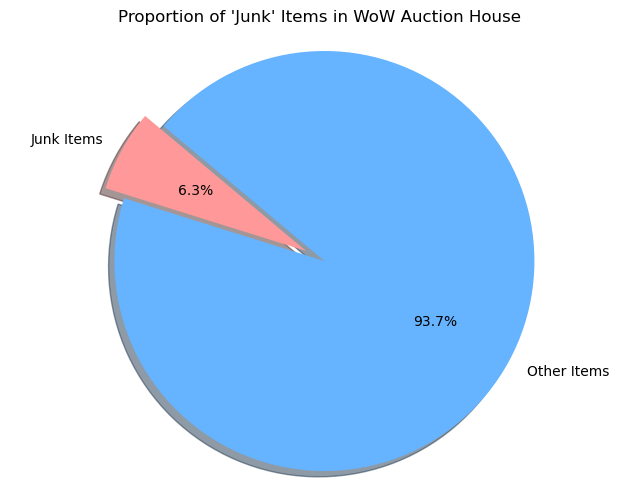

In [8]:
# set threshold for 'junk' items
high_quantity_threshold = cleaned_df['quantity'].quantile(0.75)  # top 25% of quantities
low_price_threshold = cleaned_df['unit_price'].quantile(0.25)  # bottom 25% of prices

junk_items_df = cleaned_df[(cleaned_df['quantity'] >= high_quantity_threshold) &
                           (cleaned_df['unit_price'] <= low_price_threshold)] # 'junk' items satisfy both conditions

total_items = len(cleaned_df)
junk_items_count = len(junk_items_df)
junk_percentage = (junk_items_count / total_items) * 100
print(f"Percentage of 'junk' items: {junk_percentage:.2f}%")

labels = ['Junk Items', 'Other Items']
sizes = [junk_items_count, total_items - junk_items_count]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0) 

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.axis('equal')
plt.title("Proportion of 'Junk' Items in WoW Auction House")
plt.show()

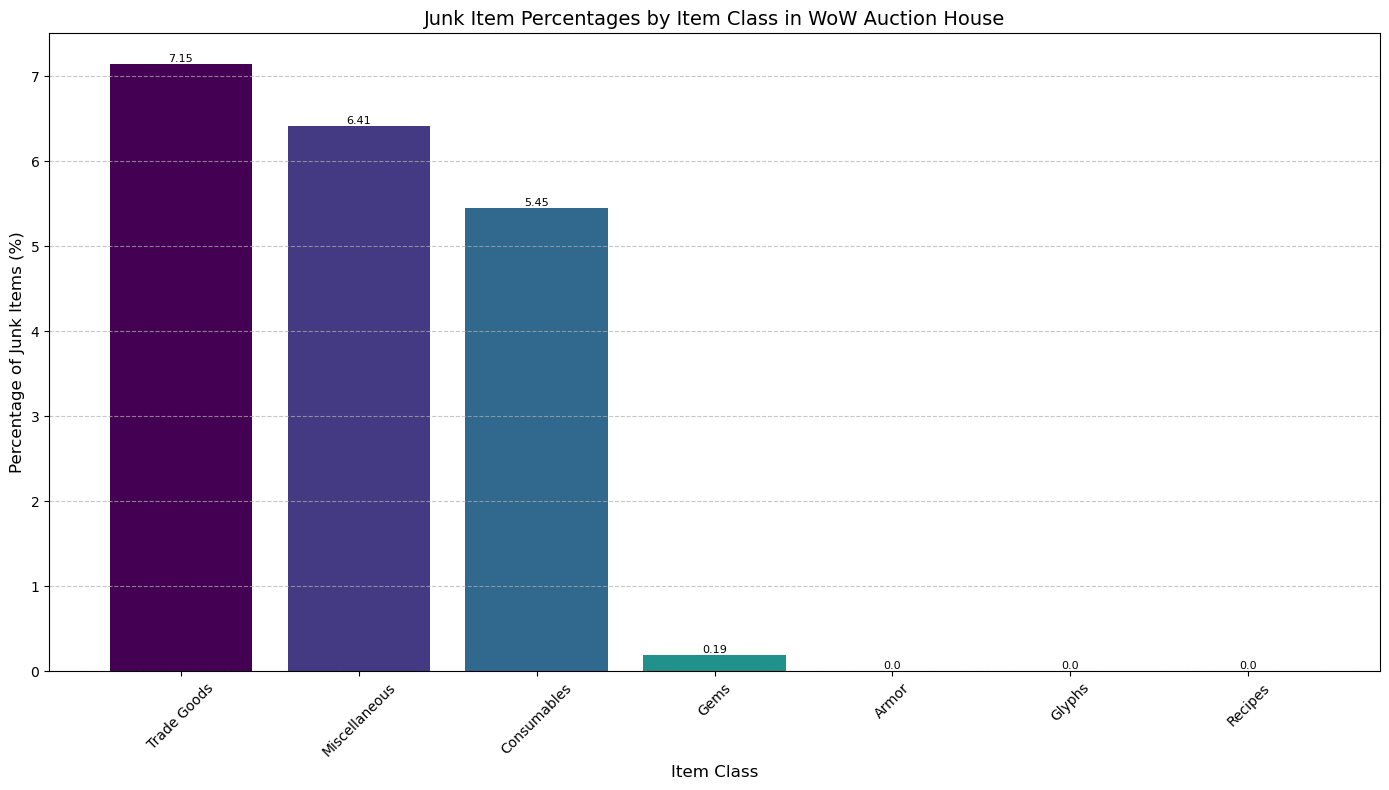

In [9]:
total_counts_by_class = cleaned_df.groupby('item.class').size()
junk_counts_by_class = junk_items_df.groupby('item.class').size()

junk_percentage_by_class = (junk_counts_by_class / total_counts_by_class) * 100

junk_percentage_by_class = junk_percentage_by_class.fillna(0)

sorted_junk_percentages = junk_percentage_by_class.sort_values(ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(sorted_junk_percentages.index, sorted_junk_percentages, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_junk_percentages))))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=8)

plt.xlabel('Item Class', fontsize=12)
plt.ylabel('Percentage of Junk Items (%)', fontsize=12)
plt.title('Junk Item Percentages by Item Class in WoW Auction House', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [10]:
trade_goods_df = cleaned_df[cleaned_df['item.class'] == 'Trade Goods']


In [11]:
junk_in_trade_goods = trade_goods_df[(trade_goods_df['quantity'] >= high_quantity_threshold) & 
                                     (trade_goods_df['unit_price'] <= low_price_threshold)]


In [13]:
junk_item_quantities = junk_in_trade_goods.groupby('item.name')['quantity'].sum()
sorted_junk_items = junk_item_quantities.sort_values(ascending=False)


In [14]:
top_n = 20
top_junk_items = sorted_junk_items.head(top_n)


In [15]:
total_junk_quantity = top_junk_items.sum()
top_junk_items_percentage = (top_junk_items / total_junk_quantity) * 100


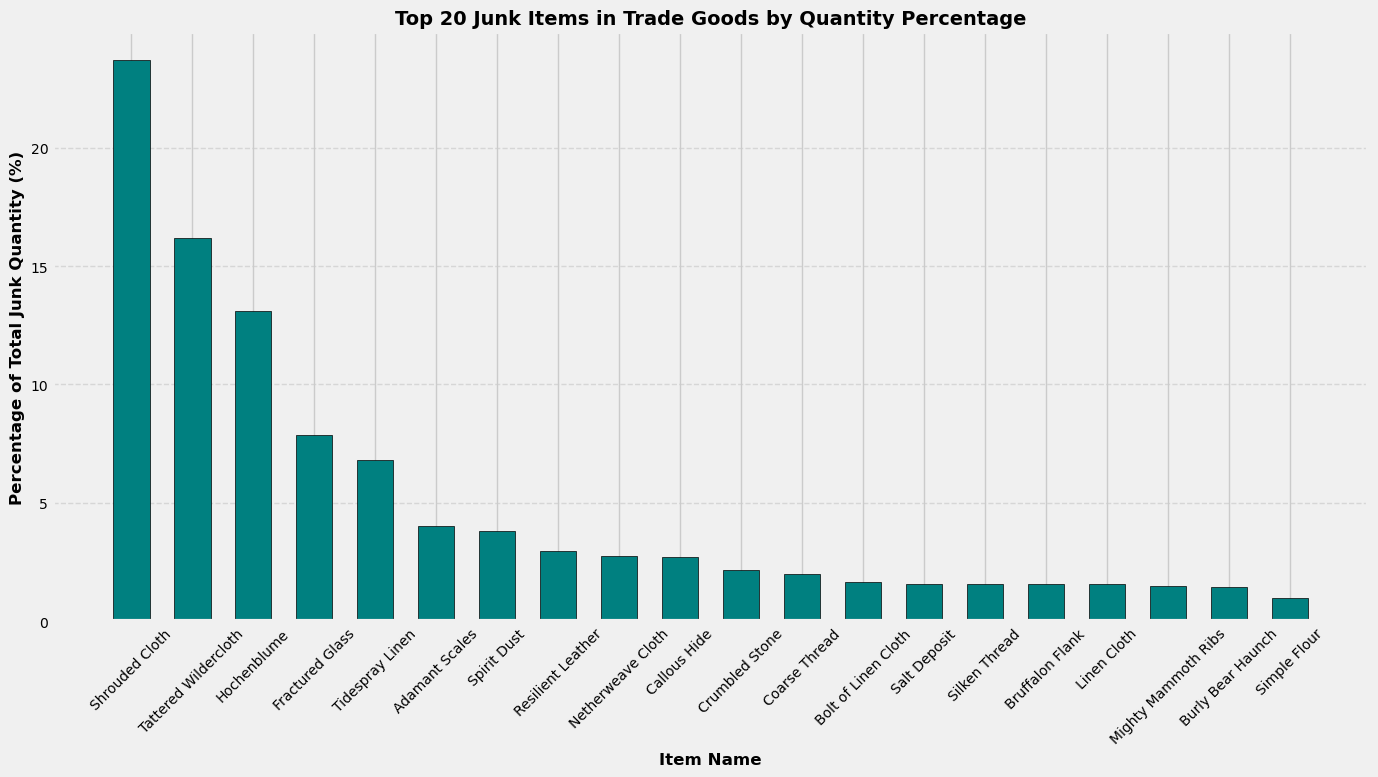

In [17]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14, 8))
bars = plt.bar(top_junk_items_percentage.index, top_junk_items_percentage, color='teal', edgecolor='black', width=0.6)

plt.xlabel('Item Name', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Total Junk Quantity (%)', fontsize=12, fontweight='bold')
plt.title('Top 20 Junk Items in Trade Goods by Quantity Percentage', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customizing the plot's ticks for a cleaner look
plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()